In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import sklearn.metrics.pairwise as pairwise

In [2]:

NUM_TAGS_USED = 100

tagDictionary = {}
idCounter = 0

data = pd.read_table('data/tags.dat', delimiter='::', engine='python')
data = data.drop(columns=['timestamp'])
data['tag'] = data['tag'].astype(str).str.lower().str.strip()
tags = sorted(data['tag'].unique())
used_tags = data['tag'].value_counts().index.tolist()[:NUM_TAGS_USED]
data = data[data['tag'].isin(used_tags)]

tags = sorted(data['tag'].unique())
tagDictionary = {tag: i for i, tag in enumerate(tags)}
data['tagID'] = (data['tag'].map(tagDictionary)).astype(int)

data['userID'] = data['userID'].astype(int)
data['movieID'] = data['movieID'].astype(int)

validUserIDs = np.argsort(sorted(data['userID'].unique()))
validUserIDMappings = {userID: validUserIDs[i] for i, userID in enumerate(data['userID'].unique())}
data['userID'] = data['userID'].map(validUserIDMappings).astype(int)

validMovieIDs = np.argsort(sorted(data['movieID'].unique()))
validMovieIDMappings = {movieID: validMovieIDs[i] for i, movieID in enumerate(data['movieID'].unique())}
data['movieID'] = data['movieID'].map(validMovieIDMappings).astype(int)

numTags = len(data['tag'].unique())
numUsers = len(data['userID'].unique())
numMovies = len(data['movieID'].unique())

In [3]:
invertedTagDictionary = {v: k for k,v in tagDictionary.iteritems()}

In [4]:
data.to_csv('reduced_data.csv')

In [5]:
def normalize_R(R_input):
    numRows = np.shape(R_input)[0]
    numCols = np.shape(R_input)[1]
    sumOverRows = np.sum(R_input, axis=0).reshape((1,numCols))
    sumOverCols = np.sum(R_input, axis=1).reshape((numRows,1))
    print(np.shape(sumOverRows*sumOverCols))
    return np.divide(R_input, np.sqrt(sumOverCols*sumOverRows))

In [6]:
Rut = np.zeros((numUsers, numTags))
def build_Rut():
    for i, row in data.iterrows():
        userID = row['userID']
        tagID = row['tagID']
        Rut[userID][tagID] += 1

build_Rut()
Rut = normalize_R(Rut)

(1818, 100)


In [7]:

Rud = np.zeros((numUsers, numMovies))

def build_Rud():
    for i, row in data.iterrows():
        userID = row['userID']
        movieID = row['movieID']
        Rud[userID][movieID] = 1

build_Rud()
print Rud

[[ 1.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [8]:
Rtd = np.zeros((numTags, numMovies))
Rtd_binary = np.zeros((numTags, numMovies))
W_dict = collections.defaultdict(set)

def build_Rtd():
    for i, row in data.iterrows():
        tagID = row['tagID']
        movieID = row['movieID']
        W_dict[movieID].add(tagID)
        Rtd[tagID][movieID] += 1
        Rtd_binary[tagID][movieID] = 1
build_Rtd()
Rtd = normalize_R(Rtd)
    

(100, 5374)


In [9]:
W = pairwise.pairwise_distances(Rtd_binary.T, metric='jaccard')
W = np.ones(W.shape) - W
print(W)
print (W.shape)


/Users/Rifath/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


[[ 1.          0.06666667  0.07142857 ...,  0.14285714  0.          0.        ]
 [ 0.06666667  1.          0.         ...,  0.          0.          0.        ]
 [ 0.07142857  0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.14285714  0.          0.         ...,  1.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          1.          1.        ]]
(5374, 5374)


In [371]:

beta = 0.9
alpha = (1-beta)/3
gamma = (1-beta)/3
eta = (1-beta)/3

In [372]:
def D_sumrows(R):
    D = np.sum(R, axis=1)
    D = np.diag(D)
    return D


D_ut = D_sumrows(Rut)
D_tu = D_sumrows(Rut.T)

D_td = D_sumrows(Rtd)
D_dt = D_sumrows(Rtd.T)

D_ud = D_sumrows(Rud)
D_du = D_sumrows(Rud.T)

D = D_sumrows(W)

L = D - W

elementsDict = {}

def buildLprime():
    elementsDict[(0,0)] = alpha*D_ut + gamma*D_ud
    elementsDict[(0, 1)] = -alpha*Rut
    elementsDict[(0, 2)] = -gamma*Rud
    elementsDict[(1,0)] = -alpha*Rut.T
    elementsDict[(1,1)] = alpha*D_tu + beta*D_td
    elementsDict[(1,2)] = -beta*Rtd
    elementsDict[(2, 0)] = -gamma*Rud.T
    elementsDict[(2, 1)] = -beta*Rtd.T
    elementsDict[(2, 2)] = beta*D_dt + gamma*D_du + eta*L
    
    row1 = np.concatenate((elementsDict[(0,0)], elementsDict[(0, 1)], elementsDict[(0, 2)]), axis=1)
    row2 = np.concatenate((elementsDict[(1,0)], elementsDict[(1, 1)], elementsDict[(1, 2)]), axis=1)
    row3 = np.concatenate((elementsDict[(2,0)], elementsDict[(2, 1)], elementsDict[(2, 2)]), axis=1)
    
    return np.concatenate((row1, row2, row3), axis=0)


L_prime = buildLprime()

In [373]:
def buildDprime():
    d1 = elementsDict[(0, 0)]
    d2 = elementsDict[(1, 1)]
    d3 = beta*D_dt + gamma*D_du + eta*D
    
    row1 = np.concatenate((d1, np.zeros((numUsers, numTags)), np.zeros((numUsers, numMovies))), axis=1)
    row2 = np.concatenate((np.zeros((numTags, numUsers)), d2, np.zeros((numTags, numMovies))), axis=1)
    row3 = np.concatenate((np.zeros((numMovies, numUsers)), np.zeros((numMovies, numTags)), d3),axis=1)
    
    return np.concatenate((row1, row2, row3), axis=0)

D_prime = buildDprime()

In [374]:
w, v = np.linalg.eigh(L_prime)
print w
print v

[  7.92911459e-16   3.24013998e-02   3.28175830e-02 ...,   2.49923319e+01
   2.74937780e+01   3.15751303e+01]
[[  1.17105332e-02   1.17231603e-04  -9.89828343e-05 ...,  -1.10795716e-07
    9.48827020e-08  -8.02838121e-08]
 [  1.17105332e-02   1.13045420e-03  -1.25352413e-03 ...,   2.31375854e-06
    4.16306076e-08   1.39926563e-06]
 [  1.17105332e-02  -5.10003377e-02  -7.00444768e-04 ...,  -9.03096314e-09
    4.43800327e-09  -5.01729489e-09]
 ..., 
 [  1.17105332e-02   6.12785309e-05  -5.78479268e-05 ...,   7.22676995e-06
   -8.86564912e-06   8.31827654e-06]
 [  1.17105332e-02   2.49144005e-05  -6.63263545e-05 ...,   1.19218524e-05
   -3.04737308e-06   6.60834007e-06]
 [  1.17105332e-02   2.49144005e-05  -6.63263545e-05 ...,   1.19218524e-05
   -3.04737308e-06   6.60834007e-06]]


In [385]:
K = 350
H = v[:, 1:(K+1)]
H_rows = np.shape(H)[0]
M = H[H_rows-numMovies:,:]
invertedMovieIDS = {v: k for k,v in validMovieIDMappings.iteritems()}
M_sim = pairwise.pairwise_distances(M, metric='cosine')
M_sim = np.ones(M_sim.shape) - M_sim

In [386]:
'''
movies_data = pd.read_table('data/movies.dat', delimiter='::', engine='python')
movies_data['movieID'] = movies_data['movieID'].astype(int)
movies_data['movieName'] = movies_data['movieName'].astype(str)
movies_data['tags'] = movies_data['tags'].astype(str)

movieIDToName = {}
movieIDToTags = {}
for i, row in movies_data.iterrows():
    if row['movieID'] not in validMovieIDMappings:
        continue
    movieIDToName[row['movieID']] = row['movieName']
    movieIDToTags[row['movieID']] = row['tags']



for i in xrange(len(M_sim)):
    row = M_sim[i]
    mostSimilarMovieID = np.argsort(row)[-2]
    
    mostSimilarMovieActualID = invertedMovieIDS[mostSimilarMovieID]
    actualCurrentID = invertedMovieIDS[i]
    #print "Movie: ", movieIDToName[actualCurrentID], " is most similar to ", movieIDToName[mostSimilarMovieActualID], i, mostSimilarMovieID
    #print "Tags for Movie:", movieIDToTags[actualCurrentID], "  Tags for most similar Movie: ", movieIDToTags[mostSimilarMovieActualID]
    #print '\n'
'''
    

'\nmovies_data = pd.read_table(\'data/movies.dat\', delimiter=\'::\', engine=\'python\')\nmovies_data[\'movieID\'] = movies_data[\'movieID\'].astype(int)\nmovies_data[\'movieName\'] = movies_data[\'movieName\'].astype(str)\nmovies_data[\'tags\'] = movies_data[\'tags\'].astype(str)\n\nmovieIDToName = {}\nmovieIDToTags = {}\nfor i, row in movies_data.iterrows():\n    if row[\'movieID\'] not in validMovieIDMappings:\n        continue\n    movieIDToName[row[\'movieID\']] = row[\'movieName\']\n    movieIDToTags[row[\'movieID\']] = row[\'tags\']\n\n\n\nfor i in xrange(len(M_sim)):\n    row = M_sim[i]\n    mostSimilarMovieID = np.argsort(row)[-2]\n    \n    mostSimilarMovieActualID = invertedMovieIDS[mostSimilarMovieID]\n    actualCurrentID = invertedMovieIDS[i]\n    #print "Movie: ", movieIDToName[actualCurrentID], " is most similar to ", movieIDToName[mostSimilarMovieActualID], i, mostSimilarMovieID\n    #print "Tags for Movie:", movieIDToTags[actualCurrentID], "  Tags for most similar Movi

In [387]:
'''
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

M = H[H_rows-numMovies:,:]
T = H[numUsers:H_rows-numMovies,:]

def fit_pca(matrix, title):
    pca = PCA(n_components=2)
    pca.fit(matrix)
    firstComponent = pca.components_[0,:]
    secondComponent = pca.components_[1,:]
    x = []
    y = []
    for row in matrix:
        firstCoordinate = np.dot(firstComponent, row)
        secondCoordinate = np.dot(secondComponent, row)
        x.append(firstCoordinate)
        y.append(secondCoordinate)
    plt.figure()
    plt.plot(x, y, 'b.')
    plt.xlabel("Value of the projection onto first component")
    plt.ylabel("Value of the projection onto second component")
    plt.title(title)
    plt.show()
'''

'\nfrom sklearn.decomposition import PCA\nimport matplotlib.pyplot as plt\n\nM = H[H_rows-numMovies:,:]\nT = H[numUsers:H_rows-numMovies,:]\n\ndef fit_pca(matrix, title):\n    pca = PCA(n_components=2)\n    pca.fit(matrix)\n    firstComponent = pca.components_[0,:]\n    secondComponent = pca.components_[1,:]\n    x = []\n    y = []\n    for row in matrix:\n        firstCoordinate = np.dot(firstComponent, row)\n        secondCoordinate = np.dot(secondComponent, row)\n        x.append(firstCoordinate)\n        y.append(secondCoordinate)\n    plt.figure()\n    plt.plot(x, y, \'b.\')\n    plt.xlabel("Value of the projection onto first component")\n    plt.ylabel("Value of the projection onto second component")\n    plt.title(title)\n    plt.show()\n'

In [388]:
'''
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(M)
x,y = [],[]
moviesOfInterest = [(14, 15), (605, 603)]
for row in X_embedded:
    x.append(row[0])
    y.append(row[1])
    
'''

'\nfrom sklearn.manifold import TSNE\n\nX_embedded = TSNE(n_components=2).fit_transform(M)\nx,y = [],[]\nmoviesOfInterest = [(14, 15), (605, 603)]\nfor row in X_embedded:\n    x.append(row[0])\n    y.append(row[1])\n    \n'

In [389]:

'''
plt.scatter(x, y, s=1)

plt.scatter([x[14]],[y[14]], s=100, label='Dawn of the Dead (2004)', marker='^')
plt.scatter([x[15]], [y[15]],s=30, label='Dawn of the Dead (1978)', marker='^')
plt.scatter([x[605]], [y[605]], s=100, label='Castle in the Sky', marker='^')
plt.scatter([x[603]], [y[603]], s=20, label='My Neighbor Totoro', c='k', marker='^')

plt.legend()
'''

"\nplt.scatter(x, y, s=1)\n\nplt.scatter([x[14]],[y[14]], s=100, label='Dawn of the Dead (2004)', marker='^')\nplt.scatter([x[15]], [y[15]],s=30, label='Dawn of the Dead (1978)', marker='^')\nplt.scatter([x[605]], [y[605]], s=100, label='Castle in the Sky', marker='^')\nplt.scatter([x[603]], [y[603]], s=20, label='My Neighbor Totoro', c='k', marker='^')\n\nplt.legend()\n"

In [390]:

genres = set()
genreToID = {}
for key, val in movieIDToTags.items():
    val = val.split('|')
    for g in val:
        genres.add(g)
genreToID = {g: i for i, g in enumerate(sorted(genres))}
numGenres = len(genreToID)
genreMatrix = np.zeros((numMovies, numGenres))

for key, value in movieIDToTags.items():
    value = value.split('|')
    for g in value:
        genreMatrix[validMovieIDMappings[key]][genreToID[g]] = 1

        


In [391]:

G_sim = pairwise.pairwise_distances(genreMatrix, metric='jaccard')
G_sim = np.ones(G_sim.shape) - G_sim
print G_sim

seenPairs = set([])
while(len(seenPairs) < 10000):
    tupleToAdd = (np.random.randint(0, numMovies), np.random.randint(0, numMovies))
    tupleToAdd = tuple(sorted(list(tupleToAdd)))
    if tupleToAdd[0] == tupleToAdd[1]:
        continue
    if tupleToAdd in seenPairs:
        continue
    seenPairs.add(tupleToAdd)
    
embedding_x = [M_sim[i][j] for i,j in seenPairs]
genre_y = [G_sim[i][j] for i,j in seenPairs]

        


[[ 1.          0.          0.         ...,  0.5         0.33333333  0.        ]
 [ 0.          1.          0.25       ...,  0.          0.2         0.        ]
 [ 0.          0.25        1.         ...,  0.          0.25        0.33333333]
 ..., 
 [ 0.5         0.          0.         ...,  1.          0.25        0.        ]
 [ 0.33333333  0.2         0.25       ...,  0.25        1.          0.        ]
 [ 0.          0.          0.33333333 ...,  0.          0.          1.        ]]


In [392]:
'''
plt.figure()
plt.scatter(embedding_x, genre_y)
plt.show()
'''

'\nplt.figure()\nplt.scatter(embedding_x, genre_y)\nplt.show()\n'

Text(0.759005,0.311905,u'$R = 0.366$')

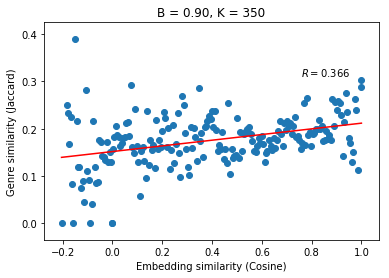

In [393]:
from scipy.stats import binned_statistic

num_bins = 200
binned_stats = binned_statistic(embedding_x, genre_y, bins=num_bins)
bins = binned_stats.binnumber

bin_x_avgs = {i: np.mean([x for j,x in enumerate(embedding_x) if bins[j] == i]) for i in range(1, num_bins+1)}
bin_y_avgs = binned_stats.statistic

x = [bin_x_avgs[i] for i in range(1,num_bins+1)]
y = bin_y_avgs

x = np.nan_to_num(x)
y = np.nan_to_num(y)

plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)), c='r')
plt.xlabel('Embedding similarity (Cosine)')
plt.ylabel('Genre similarity (Jaccard)')
plt.title('B = %0.2f, K = %d' % (beta, K))

order = 1
c = 'r'
coeffs = np.polyfit(x, y, order)
intercept = coeffs[-1]
slope = coeffs[-2]
power = coeffs[0] if order == 2 else 0

minxd = np.min(x)
maxxd = np.max(x)

xl = np.array([minxd, maxxd])
yl = power * xl ** 2 + slope * xl + intercept

#Plot trendline
plt.plot(xl, yl, c, alpha=alpha)

#Calculate R Squared
p = np.poly1d(coeffs)

ybar = np.sum(y) / len(y)
ssreg = np.sum((p(x) - ybar) ** 2)
sstot = np.sum((y - ybar) ** 2)
Rsqr = ssreg / sstot


    #Plot R^2 value
plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(y) + 0.2 * np.min(y),
             '$R = %0.3f$' % np.sqrt(Rsqr))